### ライブラリのimport

In [1]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
%matplotlib inline
import pickle
from permutation_feature_importance.PermutationFeatureImportance import PermutationFeatureImportance 

## 解析用の元データを読み込み

In [5]:
df = pd.read_excel('modify_preprocess_train_data.xlsx')

In [6]:
# 線量予測で使えない特徴量を削除する
drop_columns = ['accession', 'scan protocol', 'scan series', 'scanning length', 'CTDIw phantom type',
                'kV', 'mean mA', 'max mA', 'pitch factor', 'nomial total collimation width',
                'exposure time per rotation', 'exposure time', 'study_date', 'id', 'DLP', 'target region']

df = df.drop(drop_columns, axis=1)
df.head(2)

,Mean CTDIvol,age,gender,height_cm,weight_kg,scan_area,scan_method,bmi,body_surface_area,bmr,category_bmi,age_era,bmi_body_surface_area_category,age_weight_kg_category,scan_area_method_combine,scan_area_method_bmi_catgory_combine,bmi_bsa_cat_scan_area_method_combine,age_weight_cat_scan_area_method_combine,predicted_exposure_time,predicted_pitch_factor
0,5.86,86,F,150.0,49.1,胸部CT,単純,21.82,1.421484,1000.01,normal weight,80,8,8,胸部CT_単純,胸部CT_単純_normal weight,8胸部CT_単純,8胸部CT_単純,0.5,1.38
1,7.41,61,M,163.0,74.0,胸部CT,単純,27.85,1.797322,1487.40,obesity class1,60,2,7,胸部CT_単純,胸部CT_単純_obesity class1,2胸部CT_単純,7胸部CT_単純,0.5,1.00


In [11]:
df['bmi_body_surface_area_category'] = df['bmi_body_surface_area_category'].astype('category')
df['age_weight_kg_category'] = df['age_weight_kg_category'].astype('category')

### 前処理

In [7]:
# Ordinal EncoderとTarget Encoderの使い分けを決める
# target encodingはできるだけカテゴリ数が多いものが良い
from sklearn.preprocessing import OrdinalEncoder
from category_encoders import TargetEncoder

te_columns = [ 'scan_area', 'scan_area_method_combine', 'scan_area_method_bmi_catgory_combine',
              'bmi_bsa_cat_scan_area_method_combine', 'age_weight_cat_scan_area_method_combine',]
oe_columns = ['gender', 'scan_method', 'category_bmi', 'bmi_body_surface_area_category']

oe = OrdinalEncoder()
oe.set_output(transform='pandas')

df[oe_columns] = oe.fit_transform(df[oe_columns])

te = TargetEncoder()
te.fit(df[te_columns], df['Mean CTDIvol'])
df[te_columns] = te.transform(df[te_columns])

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8554 entries, 0 to 8553
Data columns (total 20 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   Mean CTDIvol                             8554 non-null   float64
 1   age                                      8554 non-null   int64  
 2   gender                                   8554 non-null   float64
 3   height_cm                                8554 non-null   float64
 4   weight_kg                                8554 non-null   float64
 5   scan_area                                8554 non-null   float64
 6   scan_method                              8554 non-null   float64
 7   bmi                                      8554 non-null   float64
 8   body_surface_area                        8554 non-null   float64
 9   bmr                                      8554 non-null   float64
 10  category_bmi                             8554 no

### LightGBMで学習

In [9]:
target = 'Mean CTDIvol'
X = df.drop(target, axis=1)
y = df[target]

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
#                                                     shuffle=True, random_state=42)

In [10]:
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [11]:
# デフォルト条件でlightbgmを行う
from sklearn.model_selection import KFold
import numpy as np

objective = 'mae' # 'mse' or 'mae'

params = {
    'objective': objective,
    'bagging_fraction': 0.9998314836380925,
    'bagging_freq': 27,
    'extra_trees': False,
    'feature_fraction': 0.371543939464228,
    'lambda_l1': 1.079557797273759e-05,
    'lambda_l2': 2.769373820051388e-05,
    'learning_rate': 0.0817227284210271,
    'max_depth': 17,
    'min_data_in_leaf': 4,
    'min_gain_to_split': 0.18828283626266706,
    'min_sum_hessian_in_leaf': 0.0005010492693552818,
    'num_leaves': 56,
    'path_smooth': 5}
test_scores = []
models = []

kf = KFold(n_splits=5, shuffle=True, random_state=42)
for fold, (tr_idx, va_idx) in enumerate(kf.split(X)):
    X_tr = X.iloc[tr_idx]
    X_va = X.iloc[va_idx]
    y_tr = y.iloc[tr_idx]
    y_va = y.iloc[va_idx]
    
    lgb_train = lgb.Dataset(X_tr, y_tr)
    lgb_eval = lgb.Dataset(X_va, y_va, reference=lgb_train)
    
    model = lgb.train(params,
                      lgb_train,
                      num_boost_round=1000,
                      valid_sets=[lgb_train, lgb_eval],
                      valid_names=['train', 'valid'],
                      callbacks=[lgb.early_stopping(100),
                                 lgb.log_evaluation(50)])
    
    models.append(model.best_iteration)
    y_va_pred = model.predict(X_va, num_iteration=model.best_iteration)
    score = mean_absolute_error(y_va, y_va_pred)
    print(f'fold {fold+1} MSE valid: {score:.2f}')
    print('')
    
    # スコア、モデル、予測値の格納
    test_scores.append(score)

# クロスバリデーションの平均スコア
cv_score = np.mean(test_scores)
print(f'CV score: {cv_score:.2f}')

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002025 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1981
[LightGBM] [Info] Number of data points in the train set: 6843, number of used features: 19
[LightGBM] [Info] Start training from score 10.870000
Training until validation scores don't improve for 100 rounds
[50]	train's l1: 1.65266	valid's l1: 1.75618
[100]	train's l1: 1.38747	valid's l1: 1.70024
[150]	train's l1: 1.27658	valid's l1: 1.6925
[200]	train's l1: 1.20296	valid's l1: 1.68526
[250]	train's l1: 1.14703	valid's l1: 1.68456
[300]	train's l1: 1.0966	valid's l1: 1.68267
[350]	train's l1: 1.05838	valid's l1: 1.6801
[400]	train's l1: 1.02313	valid's l1: 1.68052
Early stopping, best iteration is:
[347]	train's l1: 1.06107	valid's l1: 1.6794
fold 1 MSE valid: 1.68

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, 

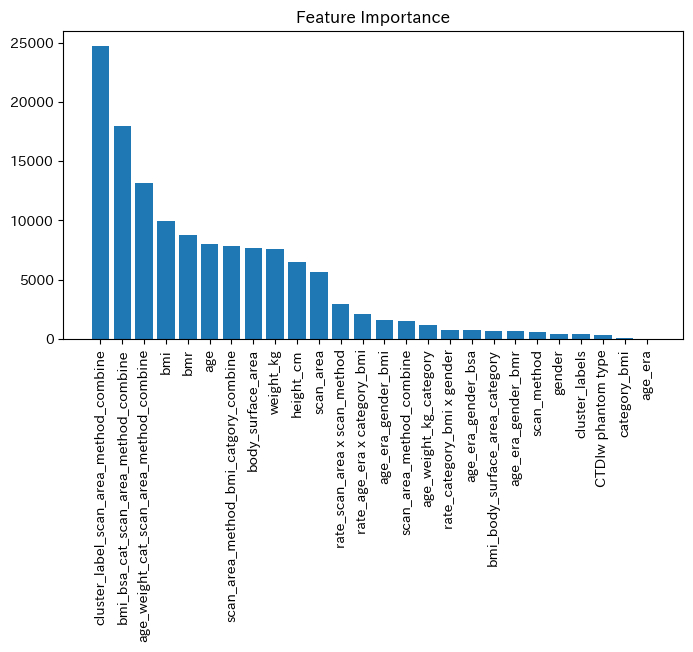

In [154]:
# 特徴量の重要度の可視化
importances = model.feature_importance(importance_type='gain')
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(8, 4))
plt.title('Feature Importance')
plt.bar(range(len(indices)), importances[indices])
plt.xticks(range(len(indices)), X.columns[indices], rotation=90)
plt.show()

### Permutation Feature Importance

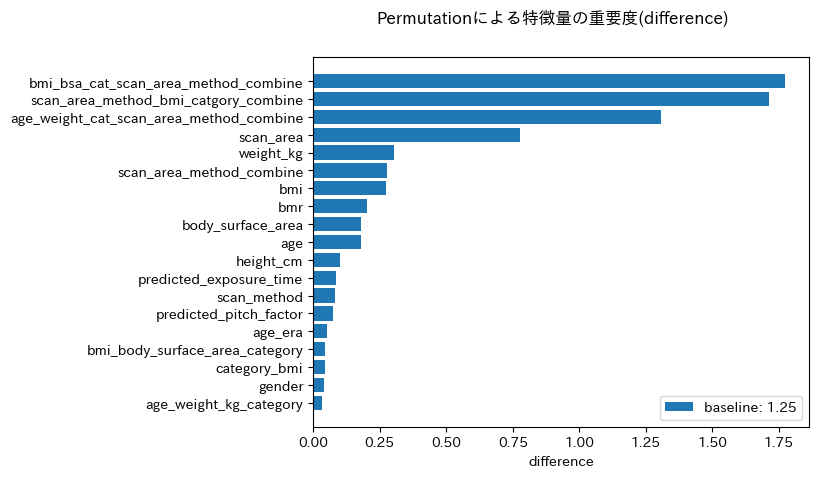

In [25]:
from sklearn.metrics import mean_absolute_error

pfi = PermutationFeatureImportance(model, X, y, X.columns, mean_absolute_error)

pfi.permutation_feature_importance(n_shuffle=5)

pfi.plot()

In [12]:
pred = model.predict(X)

In [15]:
df = pd.read_excel('modify_preprocess_train_data.xlsx')

In [16]:
df['pred'] = pred
df['diff'] = df['Mean CTDIvol'] - df['pred']

In [20]:
df_predict_statics = df.groupby('scan_area')['diff'].describe().reset_index()

In [21]:
df_predict_statics.to_excel('predict_statistic.xlsx', index=False)

In [23]:
df_predict_statics[df_predict_statics['scan_area'] == '上腹部CT']['std']

0    2.069843
Name: std, dtype: float64

In [24]:
df_predict_statics

,scan_area,count,mean,std,min,25%,50%,75%,max
0,上腹部CT,209.0,0.158299,2.069843,-4.590594,-0.795186,-0.023415,0.654773,13.718862
1,体幹部Dual Energy CT,388.0,0.221231,3.391862,-13.971622,-1.118325,-0.055566,1.073424,24.262766
2,側頭骨CT,22.0,1.216216,1.402813,-0.789631,0.008560,0.993711,1.713114,4.423156
3,冠動脈CT,307.0,-0.265635,1.326824,-3.819978,-0.858249,-0.025647,0.313238,4.222222
4,副鼻腔CT,333.0,-0.274280,3.974816,-12.888477,-1.130729,0.003172,1.467701,16.790061
5,大腿・膝・下腿CT,83.0,0.166445,3.456710,-7.899894,-2.195281,-0.140635,2.064087,12.905625
6,歯・顎骨CT,199.0,0.770346,3.176886,-3.321286,-0.611283,-0.006613,0.596369,22.202743
7,肘・前腕・手関節CT,68.0,-0.180443,1.043886,-2.799474,-0.499305,-0.016697,0.039468,4.920944
8,肩・上腕・鎖骨CT,57.0,0.224422,3.215098,-7.585794,-1.657713,-0.044957,2.532687,8.555304
9,肺塞栓CT,89.0,0.544416,3.156306,-5.790316,-0.891871,-0.041587,0.592688,13.920759
